## Crassus: Development notes
---

In [63]:
# Python imports
from Bio import SeqIO, SearchIO
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from ete3 import Tree

#### Test run

`$ mamba create -c bioconda -c conda-forge --name dev_snakemake snakemake snakedeploy` # to run the test\
`$ mamba create -c conda-forge -c bioconda --name utils biopython numpy pandas emboss` # env _utils.yaml_ \
`$ mamba create -c conda-forge -c bioconda --name phylogenies mafft trimal fasttree ete3` # env _phylogenies.yaml_


### Reference crAss set

Originally I used all the genomes that we have (~2k), comprising complete and uncomplete genomes. Besides this might be too much redundancy, classification by ANI would be incorrect for uncomplete genomes. Because of this **I decide to use only the ones listed at `contigs_clustering.xlsx`, with the complete and taxonomically classified genomes from the proposal**. Using type species would be too few though. 

So, I change the whole reference set to include in the the container. 846 complete crAss genomes (excluding crass-env) in `contigs_clustering.xlsx`, but I still add the reference Bas' crass (crass001 is already in the list) and the two outgroups, so it makes 849 at the end. I change the .fasta files under `/genomes` and the proteins in `all_crass_proteins.faa` according to this. ⚠️ **WARNING** ⚠️ Because of the lack/split of TerL gene in 8 genomes, the final number is 841, read below.

Regarding the terminases, I extract them with Biopython. I grab all the trimmed, merged terminases from `bas/february_2021/terLterL_sequences_trimmed_merged.faa`:

In [20]:
# read "crassus_genomes.txt" with the target genomes ids
target_genomes = [line.strip() for line in open("crassus_genomes.txt").readlines()]

# read the .faa file with all the terminases. Store the ones from the target genomes
to_write = list()
records = SeqIO.parse("container/terL_sequences_trimmed_merged.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome in target_genomes:
        to_write.append(record)
        target_genomes.remove(genome)
        
with open("container/crass_reference_TerL.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")
                
# print genomes without a final TerL protein 
print(target_genomes)
len(target_genomes)

['3300008523_____Ga0115231_1000095', 'OAWB01000083', '3300014553_____Ga0134451_100057', 'ERR589831_NODE_127_length_97341_cov_28.7607', 'OLOZ01000093', 'OLQU01000060', 'ERR589503_NODE_260_length_95985_cov_44.2112', 'ERR589804_NODE_183_length_96082_cov_14.9851']


8

Note well the 8 genomes without a TerL gene. **I remove them from the reference set so far**. 

In [21]:
# remove them from the genomes folder
for genome in target_genomes:
    if os.path.isfile(f"container/genomes/{genome}.fasta"):
        print(f"deleting {genome} genome")
        os.remove(f"container/genomes/{genome}.fasta")
        
# remove them from `all_crass_proteins.faa` 
to_write = list()
records = SeqIO.parse("container/all_crass_proteins.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome not in target_genomes:
        to_write.append(record)

with open("container/all_crass_proteins.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")

---
### TerL tree + rest of the trees (MCP, portal?, primase?)

The reference set are 841 genomes with their proteins and terminases. I don't know how long is gonna take to align all these sequences + the sequences found by the pipeline.

`mafft-einsi` took 15 mins with 841 seqs and 93 CPUs.
- `(mafft_env) danielc@mutant5:/linuxhome/tmp/danielc/crassus_terl:time mafft-einsi --thread 93 --quiet crass_reference_TerL.faa > crass_reference_TerL.mafft-einsi`

Let's parse the tree. I want to get as much classification as I can from it. The approach I follow is looking at two uppper nodes and checking if the family/subfamily/genus is the same.

`fasttree` was quick making the tree ofc. But what about iqtree in its fastest mode? Let's run it with the reference genomes to know how long it takes and to measure the distances inter and intra genera.\
`(iqtree) danielc@mutant5:[SCREEN]:/linuxhome/tmp/danielc/crassus_terl:time iqtree -fast -T 90 -s crass_reference_TerL.mafft-einsi -B 1000 -alrt 1000`

One of the drawbacks I see is the model estimation takes too long.


Time to get the sequences for the rest of the markers. Let's start with **MCP**. This is a very split gene, but it should be easy to get it full-length since I already merged them based on the merge/leave analysis. Just look at the `3_merged` genome tables. Script `borrar/mcp/gather/mcps.py`. Most of them are OG_824 & OG_825:

1109 OG_824\
565 OG_825\
133	OG_827\
84	OG_669\
17	OG_826\
10	OG_223\

Get the MCPs faa:\
`(base) danielc@encode:~/borrar/mcp:python get_mcps.py`

Align it:\
`(mafft_env) danielc@mutant5:~/borrar/mcp:mafft-einsi --thread -1 MCP_crassphage_reference.faa > MCP_crassphage_reference.mafft-einsi`


---
### mmseqs2 clustering

I already have implemented most of it, but still have to assess the cutoff values to delimitate genera. In the proposal it is 80% of shared content using OrthoMCL. 

Last time I tried to calculate this shared content for all the genomes, but it was too intensive for my computer/CPUs, the matrix is too big to fill it in a reasonable amount of time. However, I wrote a multithreaded script for this long time ago, `create_shared-content_from_presabs.py`. Diretory `/home/danielc/borrar/shared_content` under encode, I copy all the files there.

`(base) danielc@mutant5:~/borrar/shared_content:python create_shared-content_from_presabs.py -i presabs_matrix.txt -f all_proteins.faa -o shared_content_all.txt`

Let's plot the results 

In [56]:
# read taxonomy file and save it in a dict
crass_taxonomy = dict()

tax_file = "container/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
for line in lines:
    crass_taxonomy[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }


# get the order of the gneomes in the tree
tree_file = "results/6_terl_tree/terl_tree.nwk"
t = Tree(tree_file, format=1)
#t.show()
# find the LCA of the two outgroup species
outgs_leaves = t.search_nodes(name="NC_021803|775|90") 
outgs_leaves += t.search_nodes(name="TARA_MK892509|880|3")
outgs_lca = t.get_common_ancestor(outgs_leaves)
# reroot the tree 
t.set_outgroup(outgs_lca)
# iterate the leafs and store the order
tree_order = list()
for leaf in t.iter_leaves():
    genome = leaf.name.split("|")[0]
    tree_order.append(genome)

tree_order[:10]

['NC_021803',
 'TARA_MK892509',
 'OIXH01000029',
 'OJPI01000006',
 'OKSC01000019',
 'OBHU01000008',
 'OLSE01000042',
 'OGOC01000003',
 'OHAY01000006',
 'OLND01000017']

In [60]:
# read the shared content table and re-order it according to the tree
matrix_file = "/home/dani/encode_home/borrar/shared_content/shared_content_all.txt"
df = pd.read_csv(matrix_file, sep="\t", index_col=0)

# reorder columns
df = df[tree_order]
# reorder rows
df = df.reindex(tree_order)

In [61]:
df

,NC_021803,TARA_MK892509,OIXH01000029,OJPI01000006,OKSC01000019,OBHU01000008,OLSE01000042,OGOC01000003,OHAY01000006,OLND01000017,...,ERR589546_NODE_210_length_100947_cov_66.8087,OFRY01000044,OOBV01000062,ERR589785_NODE_186_length_100996_cov_197.8,OODL01000120,ERR589746_NODE_113_length_99784_cov_98.0259,ERR589802_NODE_149_length_99518_cov_80.1538,ERR589574_NODE_216_length_101924_cov_7.87122,ERR589507_NODE_257_length_101328_cov_39.4151,Zuo_N7_NODE_1_length_101263_cov_376.698393
NC_021803,1.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
TARA_MK892509,0.03,1.00,0.02,0.01,0.00,0.01,0.01,0.01,0.01,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
OIXH01000029,0.00,0.01,1.00,0.91,0.87,0.84,0.88,0.90,0.88,0.92,...,0.03,0.03,0.02,0.02,0.02,0.03,0.03,0.02,0.03,0.02
OJPI01000006,0.00,0.00,0.90,1.00,0.88,0.84,0.85,0.88,0.87,0.90,...,0.03,0.03,0.02,0.02,0.03,0.04,0.03,0.02,0.02,0.02
OKSC01000019,0.00,0.00,0.89,0.90,1.00,0.84,0.84,0.89,0.89,0.89,...,0.02,0.02,0.02,0.02,0.02,0.04,0.03,0.01,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR589746_NODE_113_length_99784_cov_98.0259,0.00,0.00,0.06,0.06,0.07,0.06,0.05,0.06,0.07,0.04,...,0.83,0.82,0.83,0.80,0.78,1.00,0.78,0.78,0.86,0.81
ERR589802_NODE_149_length_99518_cov_80.1538,0.00,0.00,0.07,0.05,0.06,0.06,0.05,0.07,0.07,0.05,...,0.86,0.82,0.89,0.94,0.90,0.81,1.00,0.88,0.89,0.89
ERR589574_NODE_216_length_101924_cov_7.87122,0.00,0.00,0.03,0.03,0.02,0.02,0.02,0.03,0.03,0.02,...,0.86,0.84,0.90,0.94,0.96,0.81,0.87,1.00,0.87,0.84
ERR589507_NODE_257_length_101328_cov_39.4151,0.00,0.00,0.07,0.04,0.05,0.05,0.04,0.07,0.06,0.06,...,0.86,0.80,0.86,0.83,0.81,0.81,0.81,0.79,1.00,0.81


Colors of the heatmap in the proposal are from the **Spectral** R palette, which is not available in Matplotlib. To get the color codes, I use [this](https://gist.github.com/jtoll/4021792) running R directly in the encode's shell (since I don't have R installed in my Toshiba right now).

Colors are below. Remove first and last and you are ready to go (9 colors + white of 0-10% of shared content):\
"#9E0142", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD", "#5E4FA2"

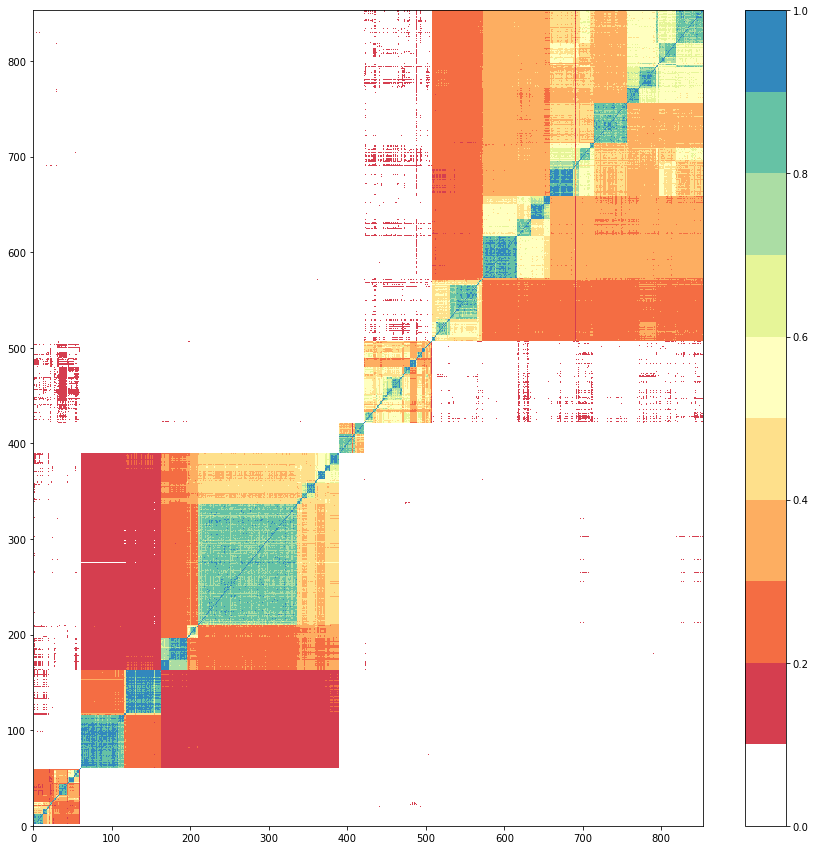

In [88]:
# draw the heatmap
cmap = colors.ListedColormap(["white", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD"])
bounds= np.arange(0,1, 0.1).tolist()
plt.rcParams["figure.figsize"] = (15,15)
heatmap = plt.pcolor(df, cmap=cmap)
plt.colorbar(heatmap, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

Heatmap shows that, in overall, values of shared protein content are lower than in the proposal. This agrees with what I saw of mmseqs2 being less sensitive than Broccoli, ie. creating more clusters. This should not be a problem as long as I find a proper cutoff to delimitate genera with this approach. 

I want to check 3 things:
- minimum value of sharing within the same genus
- maximum value of sharing between different genera

In [116]:
# store the shared content values within the same genus and between different genera
within_genus   = list()
between_genera = list()

# compute it only for the ref crassphages, discard output and found by crAssUS
genomes = [genome for genome in df.index.tolist() if genome in crass_taxonomy and genome not in ["NC_021803", "TARA_MK892509"]]

for query in genomes:
    for ref in genomes:
        if crass_taxonomy[query]["genus"] == crass_taxonomy[ref]["genus"]:
            within_genus.append(df.loc[query, ref])
        else:
            between_genera.append(df.loc[query, ref])
            
# put everything in the same df
dataset = ["within_genus"] * len(within_genus) + ["between_genera"] * len(between_genera)
values  = within_genus + between_genera
to_df = [[kind, value] for kind, value in zip(dataset, values)]

In [130]:
df_sharedc = pd.DataFrame(to_df, columns=["dataset", "value"])
df_sharedc

,dataset,value
0,within_genus,1.00
1,within_genus,0.91
2,within_genus,0.87
3,within_genus,0.84
4,within_genus,0.88
...,...,...
703916,between_genera,0.60
703917,between_genera,0.59
703918,between_genera,0.60
703919,between_genera,0.62


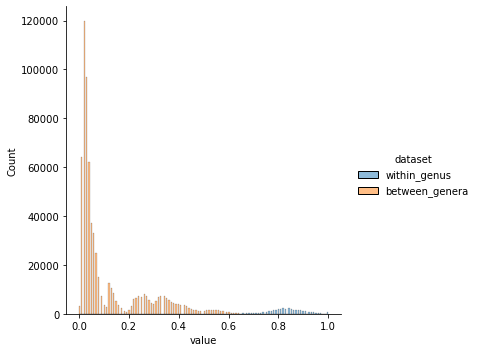

In [132]:
sns.displot(df_sharedc, x="value", hue="dataset")

(0.0, 2000.0)

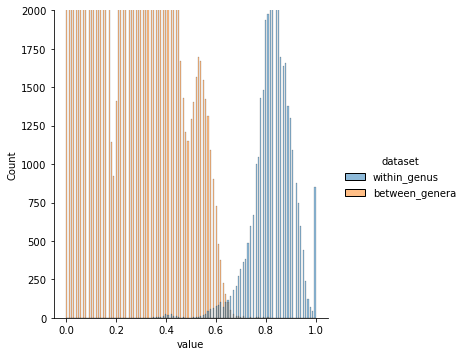

In [134]:
sns.displot(df_sharedc, x="value", hue="dataset")
plt.ylim(0, 2000)

---
### Draw genomes

Let's do something more relaxing, let's draw the genomes' alignments. BioPython GenomesDiagram's are ugly as fuck, so let's give it a try to gnoplotr. That means that I need to install R, both in my toshiba and the container. For the toshiba I follow [this link](https://linuxize.com/post/how-to-install-r-on-ubuntu-20-04/), for the container I use mamba for the version 4.1. Development under the `genomes_graphs_dev` folder, Rnotebook. ⚠️ **too shity** ⚠️ Let's move with the next method.

I was trying to avoid EasyFig, but it might be my best shot. It can be run from the command line too.

**I ask Petros about a package for this: he says there is one actually, but is busy right now and will send it to me later.** Well, the package is [clinker](https://github.com/gamcil/clinker/blob/master/images/figure.png). It might be nice, but first drawback is that it needs genbank files. 

Let's move forward with `genoplotR` for now. This is what I will need:

1) Which kind of alignment should I expect from Blast? 

x) Reorder genomes to make them start from the terminase gene. **What if the genome found does not contain a terminase?**

---
## Taxonomy assessing

I have some difficulties using singularity containers for this. NB that I need an environment with ete3 and a file with the taxonomy for the reference crassphages. It seems that the `container` directive does not work well with the `script` one, since I am not able to import ete3 using the latter. However, it works using a conda environment instead.

`mamba create -c conda-forge -c bioconda -c etetoolkit -n ete3_env ete3`\
`conda env export --name ete3_env > ete3_env.yaml`

---
### Branch and merge

I want to play with this. Let's refactor de pipeline, brach **refactor**. 

\# create branch and move to it\
`$ git checkout -b refactor`

\# change the stuff I want to change and commit it\
`$ git add .gitignore dev_notes.ipynb workflow/Snakefile workflow/rules/`\
`$ git commit -m "refactor initial rules"`

Then I just merged with master, but I didn't push before it. Just because I didn't need it. Basically I followed this [link](https://git-scm.com/book/en/v2/Git-Branching-Basic-Branching-and-Merging).  

## TESTS

In [112]:
a = [1,2,3,4]
b = [5,6,7,8]
c = a+b
x = ["first"] * len(a)
y = ["second"] * len(b)
z = x+y
j = pd.DataFrame("set":z, "values":c

SyntaxError: invalid syntax (2926451594.py, line 7)

In [124]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
